In [1]:
%matplotlib widget
import numpy as np
import cv2
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Define functions

In [2]:
def pixelify(nm_value, px_size):
    '''
    converts value in nm to px using px size
    returns value in px
    '''
    px_value = nm_value / px_size
    return px_value

def ecdf(data):
    '''
    Pass 1-D array or pd series
    returns array of x values and eCDF values
    '''
    x = np.sort(data)
    y = np.array(data, 'float')
    fac = 1/len(x)
    for i in range(len(y)):
        y[i] = (i + 1)*fac
    return x, y

### Define simulation parameters
#### Initialize values in nm for: 
> Microscope/HILO properties    <br>
> Hub properties

In [19]:
# Microscope and HILO parameters
pixel_size = 100      #nm/px in x, y
roi_x = 20000        #nm
roi_y = 20000        #nm
roi_z = 20000        #nm
slice_depth = 1000   #nm

# Hub properties
mean_hub_rad = 300   #nm
hub_rad_std = 50     #nm
hub_num = 1000        #number

#### Convert values from nanometers to pixels

In [20]:
# Microscope and HILO parameters in px
roi_x_px = pixelify(roi_x, pixel_size)                 #px
roi_y_px = pixelify(roi_y, pixel_size)                 #px
roi_z_px = pixelify(roi_z, pixel_size)                 #px
slice_depth_px  = pixelify(slice_depth, pixel_size)    #px

# Hub properties in px
mean_hub_rad_px = pixelify(mean_hub_rad, pixel_size)   #px 
hub_rad_std_px = pixelify(hub_rad_std, pixel_size)     #px

#### Initialize arrays for:
> ROI    <br>
> Hub radius (Gaussian distributed)    <br>
> x, y centers of hubs    <br>
> HILO excited slice region    <br>
> True hub volumes

In [21]:
# Array for ROI in px
roi_arr = np.zeros([int(roi_x_px), int(roi_y_px), int(roi_z_px)])

# Array of hub radii in px
hub_rad_arr = np.random.normal(mean_hub_rad_px, hub_rad_std_px, hub_num)

# Arrays of hub center coordinates in px
x_centers = np.random.randint(0 + max(hub_rad_arr), roi_x_px - max(hub_rad_arr), size = hub_num)
y_centers = np.random.randint(0 + max(hub_rad_arr), roi_y_px - max(hub_rad_arr), size = hub_num)
z_centers = np.random.randint(0 + max(hub_rad_arr), roi_z_px - max(hub_rad_arr), size = hub_num)

# HILO slice
slice_arr = np.zeros_like(roi_arr)

# True and HILO hub volume arrays
true_hub_vol_arr = pixel_size * (4/3) * np.pi * hub_rad_arr**3
hilo_hub_vol_arr = np.zeros_like(true_hub_vol_arr)

#### Generate hubs

In [22]:
# Allowed error to plot in pixels
for i in range(len(hub_rad_arr)):
    for z in range(int(np.floor(z_centers[i] - hub_rad_arr[i])), int(np.ceil(z_centers[i] + hub_rad_arr[i]))):
        for y in range(int(np.floor(y_centers[i] - hub_rad_arr[i])), int(np.ceil(y_centers[i] + hub_rad_arr[i]))):
            for x in range(int(np.floor(x_centers[i] - hub_rad_arr[i])), int(np.ceil(x_centers[i] + hub_rad_arr[i]))):
                if abs((x - x_centers[i])**2 + (y - y_centers[i])**2 + (z - z_centers[i])**2) < hub_rad_arr[i] ** 2:
                    roi_arr[x][y][z] = 2

#### Generate HILO excitation slice

In [23]:
# Center of HILO excitation slice generated randomly
slice_center_px = np.random.randint(0 + slice_depth_px/2, roi_z_px - slice_depth_px/2) #px


for z in range(int(np.round((slice_center_px - slice_depth_px/2))), int(np.round((slice_center_px + slice_depth_px/2)))):
    slice_arr[:,:,z] = slice_arr[:,:,z] + 1

#### Plot hubs with excitation beam (axes in pixels)

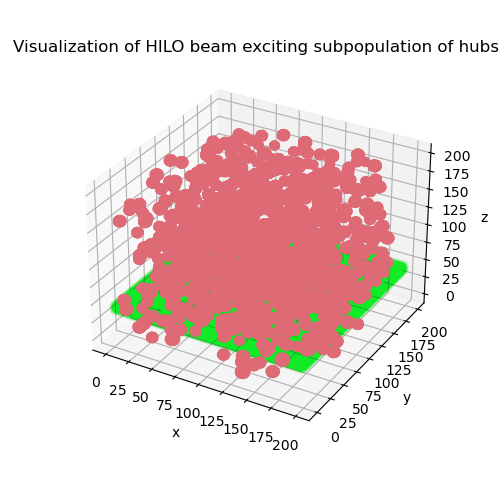

In [25]:
# Uncomment to make figure interactable
#%matplotlib widget

tot_arr = roi_arr + slice_arr

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Visualization of HILO beam exciting subpopulation of hubs')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

fig.set_figheight(5)
fig.set_figwidth(5)

pos_slice = np.where(tot_arr == 1)
pos_hubs = np.where(tot_arr == 2)
pos_excited_hubs = np.where(tot_arr == 3)

ax.scatter(pos_slice[0], pos_slice[1], pos_slice[2], alpha = .01, c = '#10eb26')
ax.scatter(pos_hubs[0], pos_hubs[1], pos_hubs[2], alpha = 1, c = '#de6a76')
ax.scatter(pos_excited_hubs[0], pos_excited_hubs[1], pos_excited_hubs[2], alpha = 1, c = '#10ebca')
plt.show();

#### Calculate hub sizes as seen by HILO

In [28]:
# Projected slice array
proj_slice_arr = np.zeros([int(roi_x_px), int(roi_y_px)]) 

proj_slice_arr = np.sum(roi_arr[:,:,int(np.round((slice_center_px - slice_depth_px/2))) \
                                          :int(np.round((slice_center_px + slice_depth_px/2)))], axis = 2)

# Normalize
proj_slice_arr = proj_slice_arr/np.amax(proj_slice_arr)

# Convert to 8-bit
image = np.array(proj_slice_arr * 255, dtype = np.uint8)

# Detect circles
circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1.2, 2 * int(np.round(min(hub_rad_arr))),
              param1 = 50,
              param2 = 5,
              minRadius = int(np.round(min(hub_rad_arr))),
              maxRadius = int(np.round(max(hub_rad_arr))))
        
# Blank slide
blank = np.zeros_like(proj_slice_arr)
blank_image = np.array(blank * 255, dtype = np.uint8)

# Calculate detected hub volume
hilo_hub_vol_arr = pixel_size * (4/3) * np.pi * circles[:,:,2].flatten()**3

#### Plot detected hubs vs actual hubs

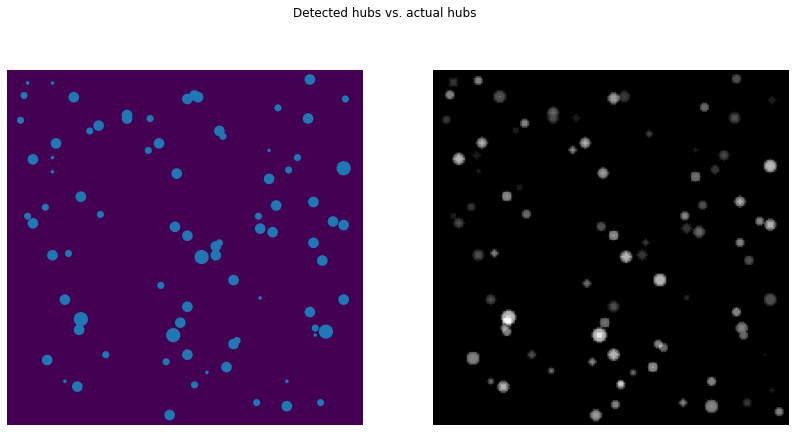

In [29]:
%matplotlib inline
# Plot detected hubs vs actual hubs
if circles is not None:
    # Convert to integer for plotting ease
    circles = np.round(circles[0, :]).astype("int")
    
    # Generate plots
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,7))
    fig.suptitle('Detected hubs vs. actual hubs')
    ax1.set_aspect('equal')
    ax1.imshow(blank_image)
    ax2.set_aspect('equal')
    ax2.imshow(image, cmap='gray')
    ax1.axis('off')
    ax2.axis('off')
    
    # Add all circles to blank plot
    for (x, y, r) in circles:
        circ = Circle((x, y), r)
        ax1.add_patch(circ)
    plt.show()

### Plot eCDF of true hub volumes

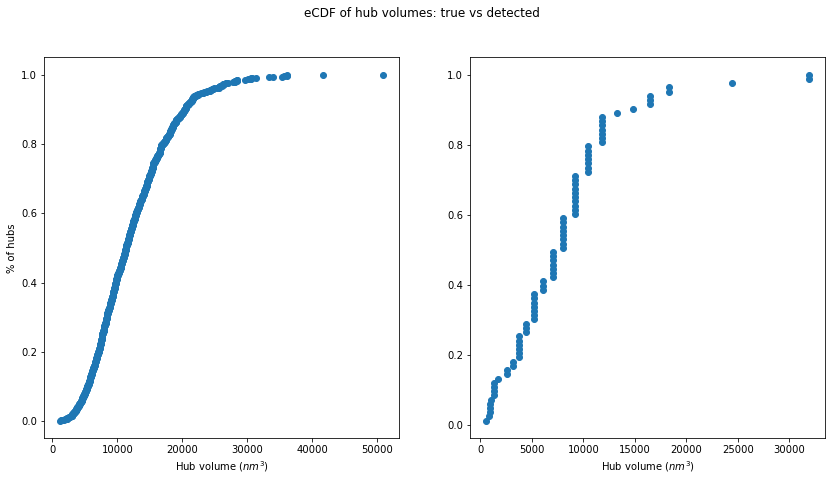

In [30]:
true_size, true_cum = ecdf(true_hub_vol_arr)
hilo_size, hilo_cum = ecdf(hilo_hub_vol_arr)

%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,7))
fig.suptitle('eCDF of hub volumes: true vs detected')
ax1.scatter(true_size, true_cum)
ax2.scatter(hilo_size, hilo_cum)
ax1.set_xlabel(r'Hub volume ($nm^3$)')
ax2.set_xlabel(r'Hub volume ($nm^3$)')
ax1.set_ylabel('% of hubs');

In [1]:
%load_ext watermark
%watermark -a "Shawn Yoshida" -d -v -p jupyterlab --iversions

Author: Shawn Yoshida

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.27.0

jupyterlab: 3.1.7

